# Data Exporation UCSF Breast MRI NACT

We will use `UCSF's Breast Cancer MRI NACT Pilot` dataset since it also has segmentation masks:

- Single site breast DCE-MRI data and segmentations from patients undergoing neoadjuvant chemotherapy (Breast-MRI-NACT-Pilot): https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22513764


In [2]:
import pandas as pd
import numpy as np
import os
import pydicom as dicom
from tqdm import tqdm
from skimage.io import imsave
import matplotlib.pylab as plt

In [6]:
clinical_rfs = pd.read_excel("/media/james/My Passport/Jetson_TX2_CMPE258/breast-mri-nact-pilot-ucsf/SharedClinicalAndRFS.xls", index_col=None, header=None)
clinical_rfs.head(10)

,0,1
0,2016-01-12,"Clinical, pathologic, and recurrence free surv..."
1,NaT,Image data may be found on TCIA:\nhttps://publ...
2,NaT,For more information on this data collection s...
3,NaT,Data provided by the Breast imaging Research P...
4,NaT,contact: birp@ucsf.edu
5,NaT,Supported by grants:\nNational Institute of He...
6,NaT,NaN
7,NaT,NaN
8,NaT,NaN
9,2016-04-05,"Added Race and binary ""Caucasian race"" columns"


In [9]:
breast_mri_nact_clinical = pd.read_csv("/media/james/My Passport/Jetson_TX2_CMPE258/breast-mri-nact-pilot-ucsf/imgs_and_seg_dicom/manifest-RbPGRCVv7392292744865323559/metadata.csv")
breast_mri_nact_clinical.head(5)

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.7695.2311.101194443955...,Breast-MRI-NACT-Pilot,NaN,https://doi.org/10.7937/K9/TCIA.2016.QHSYHJKY,UCSF-BR-01,1.3.6.1.4.1.14519.5.2.1.7695.2311.106039727348...,MR BREAST,03-29-1990,Axial-T1 locator,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,15,2.03 MB,./Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-...,2022-11-20T09:02:12.576
1,1.3.6.1.4.1.14519.5.2.1.7695.2311.137037889646...,Breast-MRI-NACT-Pilot,NaN,https://doi.org/10.7937/K9/TCIA.2016.QHSYHJKY,UCSF-BR-01,1.3.6.1.4.1.14519.5.2.1.7695.2311.106039727348...,MR BREAST,03-29-1990,Sagittal-IR3DFGRE PE1,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,60,8.20 MB,./Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-...,2022-11-20T09:02:12.913
2,1.3.6.1.4.1.14519.5.2.1.7695.2311.156797220483...,Breast-MRI-NACT-Pilot,NaN,https://doi.org/10.7937/K9/TCIA.2016.QHSYHJKY,UCSF-BR-01,1.3.6.1.4.1.14519.5.2.1.7695.2311.106039727348...,MR BREAST,03-29-1990,PJN,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,12,6.34 MB,./Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-...,2022-11-20T09:02:18.171
3,1.3.6.1.4.1.14519.5.2.1.7695.2311.129507084162...,Breast-MRI-NACT-Pilot,NaN,https://doi.org/10.7937/K9/TCIA.2016.QHSYHJKY,UCSF-BR-01,1.3.6.1.4.1.14519.5.2.1.7695.2311.106039727348...,MR BREAST,03-29-1990,PJN,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,12,6.34 MB,./Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-...,2022-11-20T09:02:20.006
4,1.3.6.1.4.1.14519.5.2.1.7695.2311.212775144500...,Breast-MRI-NACT-Pilot,NaN,https://doi.org/10.7937/K9/TCIA.2016.QHSYHJKY,UCSF-BR-01,1.3.6.1.4.1.14519.5.2.1.7695.2311.106039727348...,MR BREAST,03-29-1990,PJN,GE MEDICAL SYSTEMS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,12,6.34 MB,./Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-...,2022-11-20T09:02:23.858


## Load Breast Cancer MRI Data

In [ ]:
pe_seg_mri_path = "/media/james/My Passport/Jetson_TX2_CMPE258/breast-mri-nact-pilot-ucsf/imgs_and_seg_dicom/manifest-RbPGRCVv7392292744865323559/Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-218019-MR BREAST-74237/42000.000000-PE Segmentation thresh70-70064/1-1.dcm"
pe_seg_mri_ds = dicom.dcmread(pe_seg_mri_path)

breast_tissue_seg_path = "/media/james/My Passport/Jetson_TX2_CMPE258/breast-mri-nact-pilot-ucsf/imgs_and_seg_dicom/manifest-RbPGRCVv7392292744865323559/Breast-MRI-NACT-Pilot/UCSF-BR-01/03-29-1990-218019-MR BREAST-74237/42001.000000-Breast Tissue Segmentation-38497/1-1.dcm"
breast_tissue_seg_ds = dicom.dcmread(breast_tissue_seg_path)

In [30]:
pe_seg_mri_ds.pixel_array.shape

(60, 256, 256)

In [34]:
breast_tissue_seg_ds.pixel_array.shape[2]

256

## Visualize a Breast Cancer MRI with Mask Slice from 3D MRI

Our breast cancer MRI is `60x256` and has `256` MRI slices to make up the 3D MRI.

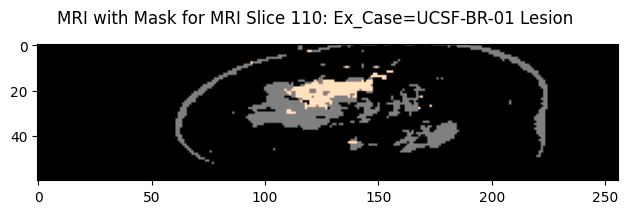

In [48]:
slice2show = 110
num_mri_slices = breast_tissue_seg_ds.pixel_array.shape[2]

# for slice2show in range(num_mri_slices, 20):
fig = plt.figure()
plt.imshow(breast_tissue_seg_ds.pixel_array[:,:,slice2show], cmap=plt.cm.gray)
plt.imshow(pe_seg_mri_ds.pixel_array[:,:,slice2show], alpha=0.5, cmap=plt.cm.copper)
fig.suptitle("MRI with Mask for MRI Slice 110: Ex_Case={} Lesion".format("UCSF-BR-01"))
fig.tight_layout()
fig.subplots_adjust(top=1.5)
#     plt.show()